In [1]:
%pip install pandas
# importing needed libraries
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
#from seaborn_qqplot import pplot

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.impute import  SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
df_train = pd.read_csv("df_train.csv")

df_train.shape

(5042, 20)

In [3]:
# boolean columns changed
df_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000381469727,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.1500015258789,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.64999389648438,Yes


In [4]:
#SeniorCitizen values changed
df_train.tail()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5037,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
5038,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
5039,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
5040,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
5041,Male,No,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [5]:
smart_features = ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
                    "TechSupport", "StreamingTV", "StreamingMovies"]

In [6]:
#smart features imputed
df_train[smart_features].isna().any()


OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
dtype: bool

In [7]:
# row with missing Churn value dropped
df_train[df_train.Churn.isna()]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [8]:
# data cleaned
df_train.isna().any().sum()

0

In [9]:
df_train.dtypes


gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [10]:
# unexpected value in TotalCharges column
df_train[df_train["TotalCharges"] == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3217,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
4669,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
4753,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


In [11]:
df_train.TotalCharges = pd.to_numeric(df_train.TotalCharges, errors='coerce') #converts " " to NaN
df_train.TotalCharges = df_train.TotalCharges.fillna(df_train.TotalCharges.median())

In [12]:
cat_columns = df_train.select_dtypes(exclude=['float', 'int'])
print(len(cat_columns.columns))
cat_columns.head()

17


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [13]:
cat_columns.tail()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
5037,Male,No,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
5038,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
5039,Female,No,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
5040,Male,Yes,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
5041,Male,No,No,No,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),No


In [14]:
cols = list(cat_columns.columns)
cols.remove('Churn')

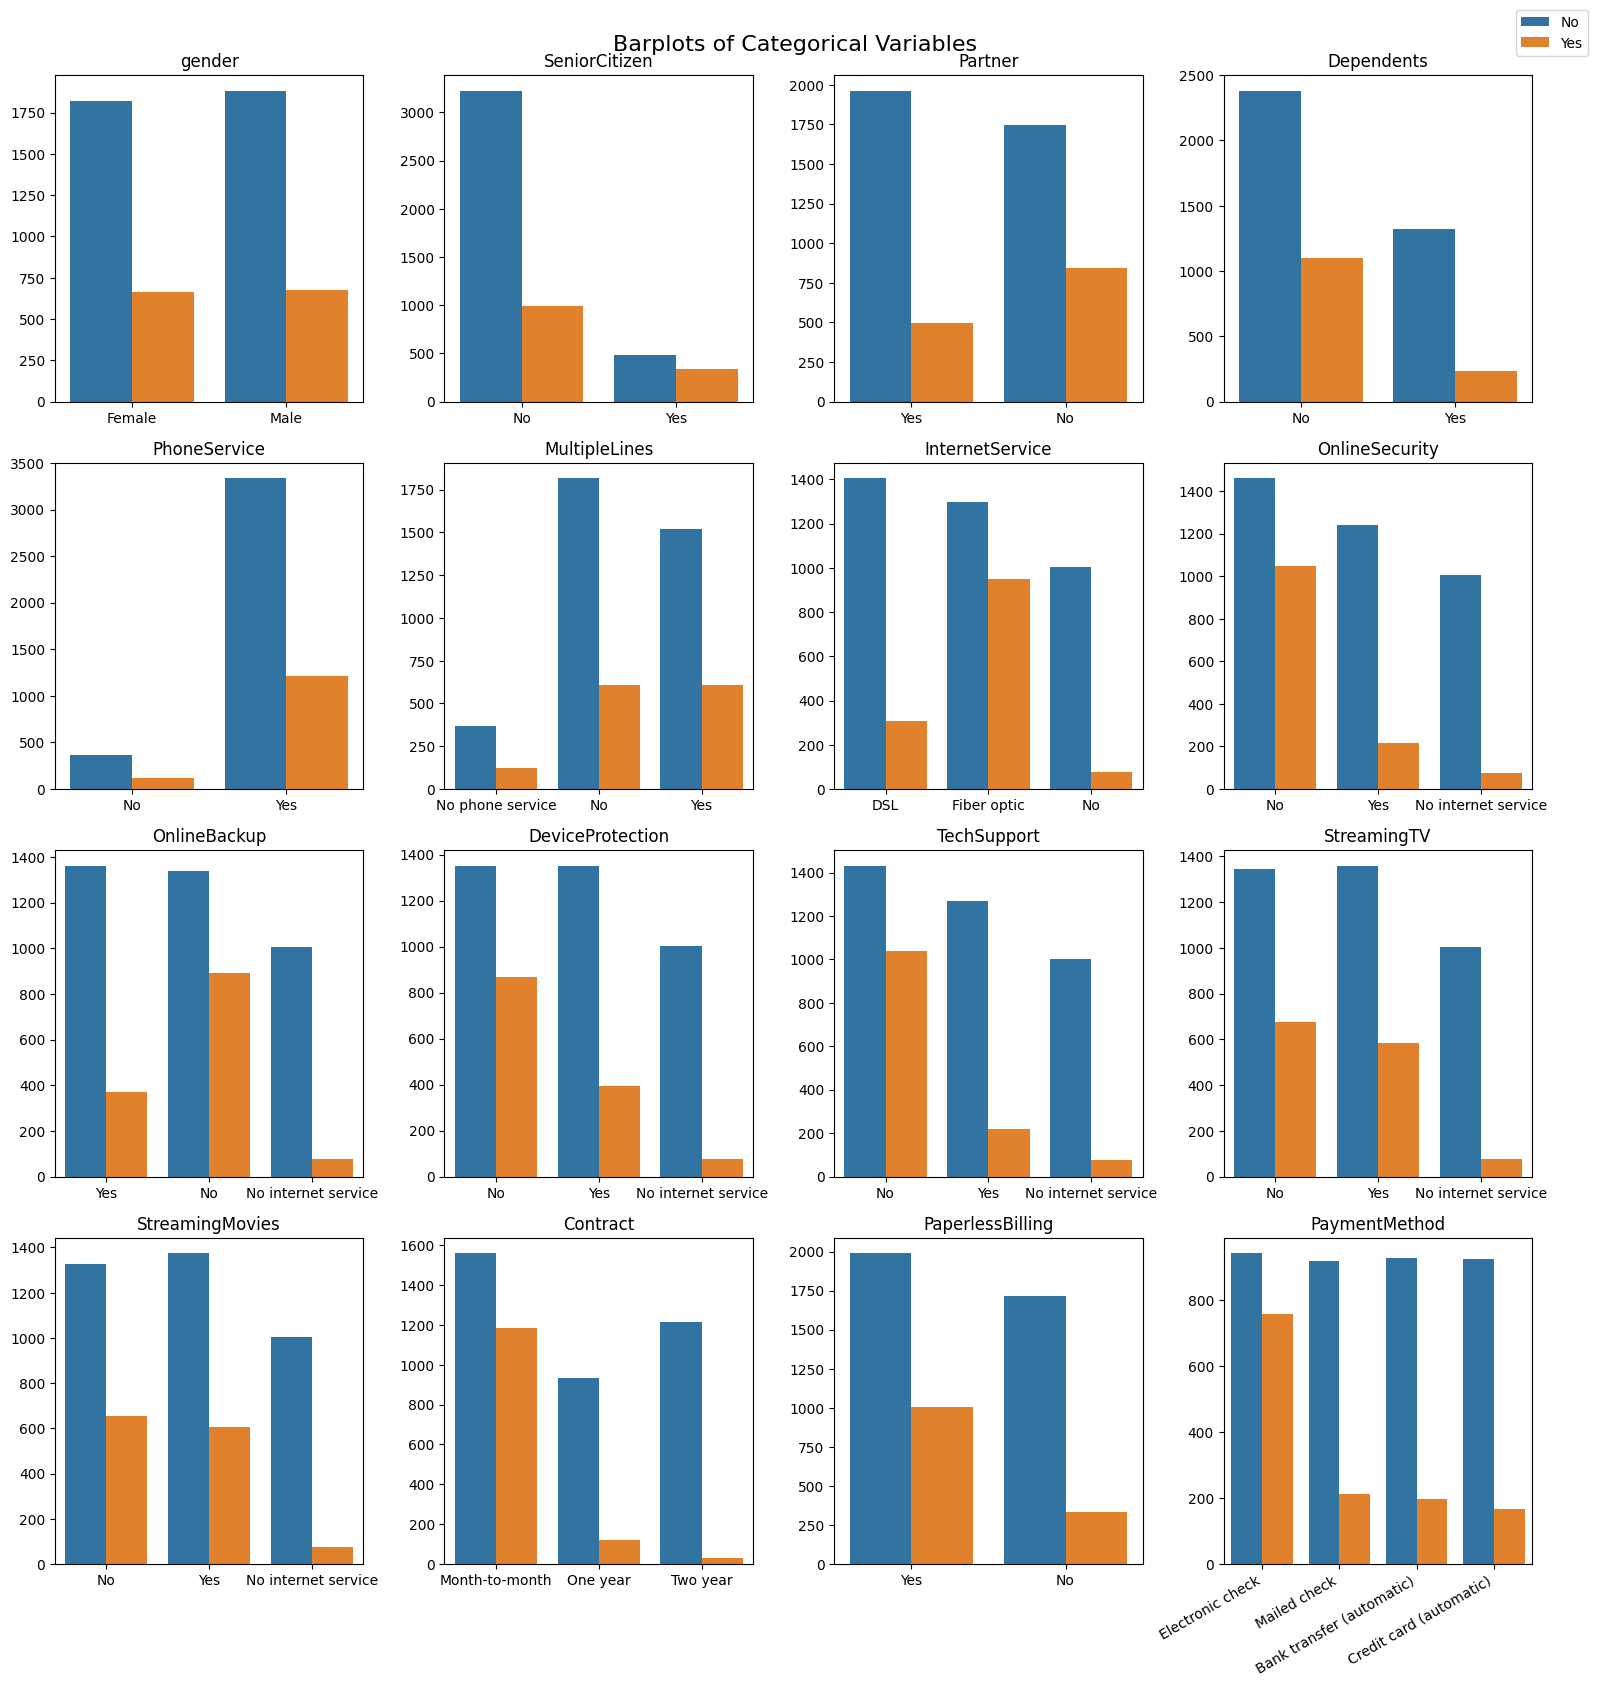

In [15]:

# set up figure and axes
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=False, figsize=(16, 16))
fig.suptitle('Barplots of Categorical Variables', fontsize=16)

#flatten axes array to loop through
axes = axes.flatten()

#access axes and create barplots
for i, cat_var  in enumerate(cols):
    ax = sns.countplot(data=cat_columns, x=cat_var, ax=axes[i], hue='Churn');
    ax.legend().set_visible(False)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(cat_var)


# Add a single legend for all the countplots outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.xticks(rotation=30, ha='right');

In [16]:
significant_variables = []
insignificant_variables = []

def chi_square_test(var):

    # Create a contingency table (cross-tabulation) of the two categorical variables
    contingency_table = pd.crosstab(df_train[var], df_train['Churn'])

    # Perform the Chi-Square test of independence
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print(f'{var}')
    print(f"Chi-Square Test of Independence Results:")
    print("Chi-Square Statistic:", chi2_stat)
    print("p-value:", p_value)
    print("Degrees of Freedom:", dof)
    print("Expected Frequencies Table:")
    print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"There is a SIGNIFICANT RELATIONSHIP between {var} and Churn.")
        significant_variables.append(var)
    else:
        print(f"There is NO SIGNIFICANT RELATIONSHIP between {var} and Churn.")
        insignificant_variables.append(var)

In [17]:
for col in cols:
    chi_square_test(var=col)
    print("****" * 20)

gender
Chi-Square Test of Independence Results:
Chi-Square Statistic: 0.021628520637713346
p-value: 0.8830796247912641
Degrees of Freedom: 1
Expected Frequencies Table:
Churn            No         Yes
gender                         
Female  1825.804046  658.195954
Male    1880.195954  677.804046
There is NO SIGNIFICANT RELATIONSHIP between gender and Churn.
********************************************************************************
SeniorCitizen
Chi-Square Test of Independence Results:
Chi-Square Statistic: 112.2962875886836
p-value: 3.0771132702736696e-26
Degrees of Freedom: 1
Expected Frequencies Table:
Churn                   No          Yes
SeniorCitizen                          
No             3104.013883  1118.986117
Yes             601.986117   217.013883
There is a SIGNIFICANT RELATIONSHIP between SeniorCitizen and Churn.
********************************************************************************
Partner
Chi-Square Test of Independence Results:
Chi-Square Statistic: 9

In [18]:
print('Insignificant variables: ', insignificant_variables)
print()
print('Significant Variables: ')
significant_variables

Insignificant variables:  ['gender', 'PhoneService']

Significant Variables: 


['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [19]:
churn_data = df_train.copy()
churn_data.to_csv('churn_data.csv', index=False)

In [20]:
churn_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [21]:
#drop duplicates
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

In [22]:
#drop gender and phone service.
df_train = df_train.drop(['gender', 'PhoneService'], axis=1)
df_train.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

In [23]:
# train test split. split data into train and eval set to maintain integrity of test set
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']

In [24]:
print(X.shape, y.shape)
#print(X_train.shape, X_eval.shape)

(5032, 17) (5032,)


In [25]:
#extract numerical and categorical features
cat_cols = list(X.select_dtypes(include='object').columns)
num_cols = list(X.select_dtypes(exclude='object').columns)

In [26]:
#reorder columns
X = X[num_cols + cat_cols]
print(X.columns)

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [27]:
#define preprocessing for categorical features
cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore') )
])


ValueError: Columns must be same length as key

In [28]:
X.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,1,29.850000,29.850000,No,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,34,56.950001,1889.500000,No,No,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,2,53.849998,108.150002,No,No,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,45,42.299999,1840.750000,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,2,70.699997,151.649994,No,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [29]:
# we don't do any numerical transformations to prevent data leakage before splitting.

cat_preprocessor = ColumnTransformer(transformers=[
   ('Num_transformer', 'passthrough', num_cols),
   ('cat_transformer', cat_transformer, cat_cols)

])


In [79]:
X_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   5032 non-null   float64
 1   MonthlyCharges                           5032 non-null   float64
 2   TotalCharges                             5032 non-null   float64
 3   SeniorCitizen_No                         5032 non-null   float64
 4   SeniorCitizen_Yes                        5032 non-null   float64
 5   Partner_No                               5032 non-null   float64
 6   Partner_Yes                              5032 non-null   float64
 7   Dependents_No                            5032 non-null   float64
 8   Dependents_Yes                           5032 non-null   float64
 9   MultipleLines_No                         5032 non-null   float64
 10  MultipleLines_No phone service           5032 no

In [67]:
X_train.columns


Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_No',
       'SeniorCitizen_Yes', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       '

In [30]:
X_prepared = cat_preprocessor.fit_transform(X)


In [31]:
#obtain transformed cat_cols columns
transformed_columns = (num_cols +
   list(cat_preprocessor.named_transformers_['cat_transformer'].named_steps['encoder'].get_feature_names_out(cat_cols) ))
len(transformed_columns)

42

In [32]:
#convert to dataframe
X_prepared = pd.DataFrame(X_prepared, columns=transformed_columns)
X_prepared.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,29.850000,29.850000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,34.0,56.950001,1889.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,53.849998,108.150002,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,45.0,42.299999,1840.750000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2.0,70.699997,151.649994,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [33]:
# handling class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=99)
X_balanced, y_balanced= smote.fit_resample(X_prepared, y)
print(X_balanced.shape, y_balanced.shape)

(7402, 42) (7402,)


In [34]:
#split dataset
#set stratify=y to ensure minority class is well represented in both sets.
X_train, X_eval, y_train, y_eval = train_test_split(X_balanced, y_balanced, test_size=0.2,
                                                    stratify=y_balanced, random_state=99)

In [35]:
print('shape of trainset: ', X_train.shape, y_train.shape)
print('shape of evaluation set: ', X_eval.shape, y_eval.shape)

shape of trainset:  (5921, 42) (5921,)
shape of evaluation set:  (1481, 42) (1481,)


In [36]:
#build numerical transformer pipeline after splitting data

num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
  ])

X_train[num_cols] = num_transformer.fit_transform(X_train[num_cols])
X_train

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6704,-0.798500,-1.548495,-0.850265,0.427755,0.572245,0.427755,0.572245,1.0,0.0,0.572245,...,0.0,1.0,0.0,0.0,0.572245,0.427755,0.000000,0.427755,0.000000,0.572245
2602,-1.127563,0.038747,-0.915506,0.000000,1.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
5552,-0.855384,0.738872,-0.645522,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,1.000000,0.000000,0.502289,0.000000,0.000000,0.497711
5589,-0.655095,1.071337,-0.380190,0.712848,0.287152,0.712848,0.287152,1.0,0.0,0.287152,...,1.0,1.0,0.0,0.0,0.000000,1.000000,0.712848,0.000000,0.287152,0.000000
4034,-1.043845,-0.998685,-0.887561,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,-0.499679,-1.683881,-0.796168,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
3614,-0.206666,1.240907,0.184122,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
4679,-0.667114,-1.694395,-0.844613,1.000000,0.000000,0.000000,1.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3438,-1.127563,-1.717177,-0.938457,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [37]:
X_train = pd.DataFrame(X_train, columns=transformed_columns)
X_train.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6704,-0.798500,-1.548495,-0.850265,0.427755,0.572245,0.427755,0.572245,1.0,0.0,0.572245,...,0.0,1.0,0.0,0.0,0.572245,0.427755,0.000000,0.427755,0.000000,0.572245
2602,-1.127563,0.038747,-0.915506,0.000000,1.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
5552,-0.855384,0.738872,-0.645522,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,1.000000,0.000000,0.502289,0.000000,0.000000,0.497711
5589,-0.655095,1.071337,-0.380190,0.712848,0.287152,0.712848,0.287152,1.0,0.0,0.287152,...,1.0,1.0,0.0,0.0,0.000000,1.000000,0.712848,0.000000,0.287152,0.000000
4034,-1.043845,-0.998685,-0.887561,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000


In [80]:
X_train.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_No',
       'SeniorCitizen_Yes', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       '

In [38]:
#model based feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=10, random_state=99)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

selector = SelectFromModel(clf, prefit=True)
X_train_reducedFeatures = selector.transform(X_train)
print('feature reduced train set shape:', X_train_reducedFeatures.shape)


[9.69018311e-02 8.54524335e-02 9.60627643e-02 9.45442555e-03
 1.19741812e-02 1.93467094e-02 2.04474901e-02 1.12351062e-02
 1.04621355e-02 1.12182372e-02 5.20758153e-03 1.04925845e-02
 1.44484579e-02 2.94925289e-02 2.04464864e-04 3.83387530e-02
 3.87118121e-05 2.91553323e-02 3.49647862e-02 1.42190477e-02
 1.04449552e-02 3.28627686e-02 2.30289001e-04 9.87079798e-03
 6.91157298e-02 5.42704771e-04 1.76679575e-02 1.27325699e-02
 1.48123573e-04 1.09740682e-02 1.03483335e-02 1.27595370e-04
 1.03304078e-02 1.05187003e-01 1.00739409e-02 1.34795142e-02
 1.90012038e-02 3.00093127e-02 1.29530062e-02 1.16119049e-02
 5.35142384e-02 9.65601207e-03]
feature reduced train set shape: (5921, 12)


In [39]:
#extract the important features

feature_names = X_train.columns

# Get the selected feature indices as a boolean mask
selected_features_mask = selector.get_support()

# Print the names of the selected features
selected_feature_names = [feature_names[i] for i, selected in enumerate(selected_features_mask) if selected]
print("Selected Features:", selected_feature_names)

Selected Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'Contract_Month-to-month', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check']


In [40]:
#apply feature reduction model transformation
X_eval_reducedFeatures = X_eval[selected_feature_names]
X_eval_reducedFeatures.head()

,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,DeviceProtection_No,TechSupport_No,Contract_Month-to-month,PaperlessBilling_Yes,PaymentMethod_Electronic check
581,1.0,75.300003,75.300003,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3338,66.0,74.600000,4798.400000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3310,32.0,73.600000,2316.850000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,37.0,19.850000,784.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5793,2.0,75.133382,156.181560,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [41]:
print('shape of evaluation set:', X_eval.shape)
print('shape of reduced features evaluation set:', X_eval_reducedFeatures.shape)

shape of evaluation set: (1481, 42)
shape of reduced features evaluation set: (1481, 12)


In [42]:
models = {
    "Linear Support vector": LinearSVC(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}
list(models.keys())

['Linear Support vector',
 'Logistic Regression',
 'Gradient Boosting',
 'AdaBoost',
 'Decision Tree',
 'Random Forest']

In [43]:

def models_trainer(models_dict, X_train, X_eval, y_train, y_eval):
  '''
  This function trains a dictionary of models and input train and evaluation sets.

  Input parameters Parameters:

  models_dict: a dictionary of models to be trained
  X_train: train set to be used to train the models
  X_eval: evaluation set to be used for evaluating model performance
  y_train: train set target
  y_eval: evaluation set target label

  Output
  prints the accuracy, recall, precision and f1_score metrics of each model

  '''

  #loop through the models
  for i in range(len(list(models_dict))):
    model = list(models_dict.values())[i]

    #train model
    model.fit(X_train, y_train)

    #make predictions
    y_train_pred = model.predict(X_train)
    y_eval_pred = model.predict(X_eval)

    #evaluation on trainset
    train_accuracy_score = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    train_precision_score = precision_score(y_true=y_train, y_pred=y_train_pred, pos_label='Yes')
    train_recall_score = recall_score(y_true=y_train, y_pred=y_train_pred, pos_label='Yes')
    train_f1_score = f1_score(y_true=y_train, y_pred=y_train_pred, pos_label='Yes')

    #evaluation on eval set.
    eval_accuracy_score = accuracy_score(y_true=y_eval, y_pred=y_eval_pred)
    eval_precision_score = precision_score(y_true=y_eval, y_pred=y_eval_pred, pos_label='Yes')
    eval_recall_score = recall_score(y_true=y_eval, y_pred=y_eval_pred, pos_label='Yes')
    eval_f1_score = f1_score(y_true=y_eval, y_pred=y_eval_pred, pos_label='Yes')


    print('Model: ', list(models_dict.keys())[i])
    print("Performance on train set:")
    print(f'Accuracy Score: {train_accuracy_score: .4f}')
    print(f'Precision Score: {train_precision_score: .4f}')
    print(f'Recall Score: {train_recall_score: .4f}')
    print(f'f1 Score: {train_f1_score: .4f}')
    print('---'*30)

    print("Performance on evaluation set:")
    print(f'Accuracy Score: {eval_accuracy_score: .4f}')
    print(f'Precision Score: {eval_precision_score: .4f}')
    print(f'Recall Score: {eval_recall_score: .4f}')
    print(f'f1 Score: {eval_f1_score: .4f}')
    print('***' * 30)
    print('\n')

In [44]:
# evaluation models performance without feature reduction
models_trainer(models_dict=models, X_train=X_train, X_eval=X_eval, y_train=y_train, y_eval=y_eval)

Model:  Linear Support vector
Performance on train set:
Accuracy Score:  0.7777
Precision Score:  0.7523
Recall Score:  0.8280
f1 Score:  0.7884
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.4146
Precision Score:  0.4514
Recall Score:  0.7895
f1 Score:  0.5744
******************************************************************************************


Model:  Logistic Regression
Performance on train set:
Accuracy Score:  0.7794
Precision Score:  0.7573
Recall Score:  0.8223
f1 Score:  0.7885
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.5003
Precision Score:  0.5003
Recall Score:  1.0000
f1 Score:  0.6670
******************************************************************************************


Model:  Gradient Boosting
Performance on train set:
Accuracy Score:  0.8743
Precision Score:  0.8779
Rec

In [45]:
#train model with reduced features
models_trainer(models_dict=models, X_train=X_train_reducedFeatures, X_eval=X_eval_reducedFeatures, y_train=y_train, y_eval=y_eval)

Model:  Linear Support vector
Performance on train set:
Accuracy Score:  0.7717
Precision Score:  0.7530
Recall Score:  0.8084
f1 Score:  0.7797
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.5003
Precision Score:  0.5003
Recall Score:  1.0000
f1 Score:  0.6670
******************************************************************************************


Model:  Logistic Regression
Performance on train set:
Accuracy Score:  0.7700
Precision Score:  0.7551
Recall Score:  0.7990
f1 Score:  0.7764
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.5003
Precision Score:  0.5003
Recall Score:  1.0000
f1 Score:  0.6670
******************************************************************************************


Model:  Gradient Boosting
Performance on train set:
Accuracy Score:  0.8740
Precision Score:  0.8685
Rec

In [46]:

gb_param_grid = {
    'n_estimators': np.arange(50, 300, 10), # Number of boosting stages to be used
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # Learning rate shrinks the contribution of each estimator
    'max_depth': np.arange(3, 12, 1), # Maximum depth of the individual estimators
    'min_samples_split': np.arange(2, 11, 1), # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 1), # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Fraction of samples used for fitting the trees
    'max_features': ['auto', 'sqrt', 'log2', None], # Number of features to consider for the best split
    'random_state': [99] # Random state for reproducibility
}



rf_param_grid = {
    'n_estimators': np.arange(200, 300, 50),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': np.arange(3, 12, 1),  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 11, 1),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 1),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'random_state': [99]  # Random state for reproducibility
}

rand_search_models = [('Gradient Boosting', GradientBoostingClassifier(), gb_param_grid),
                    ('Random Forest', RandomForestClassifier(), rf_param_grid)]

In [47]:
model_best_params = {}
best_models = {}
best_score = {}

for name, model, params in rand_search_models:
  random_search = RandomizedSearchCV(estimator=model,
                                      param_distributions=params,
                                      n_iter=100,
                                      cv=3,
                                      n_jobs=-1)

  random_search.fit(X_train_reducedFeatures, y_train)
  model_best_params[name] = random_search.best_params_
  best_models[name] = random_search.best_estimator_
  best_score[name] = random_search.best_score_

for name in model_best_params:
  print(f'Best hyperparameters for {name}:')
  print(model_best_params[name])
  print(f'Best Score for {name}:')
  print(best_score[name])
  print('***'*30)
  print('\n')



Best hyperparameters for Gradient Boosting:
{'subsample': 0.9, 'random_state': 99, 'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.1}
Best Score for Gradient Boosting:
0.859989887116738
******************************************************************************************


Best hyperparameters for Random Forest:
{'random_state': 99, 'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 11, 'criterion': 'gini', 'bootstrap': False}
Best Score for Random Forest:
0.8586389065624704
******************************************************************************************




In [48]:
best_models

{'Gradient Boosting': GradientBoostingClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                            n_estimators=130, random_state=99, subsample=0.9),
 'Random Forest': RandomForestClassifier(bootstrap=False, max_depth=11, max_features='log2',
                        min_samples_split=7, n_estimators=200, random_state=99)}

In [49]:
optimized_gb_classifier = best_models['Gradient Boosting']
optimized_rf_classifier = best_models['Random Forest']

In [50]:
#train best model on full trainset
optimized_gb_classifier.fit(X_train_reducedFeatures, y_train)

#predict
y_pred_gb = optimized_gb_classifier.predict(X_eval_reducedFeatures)

#evaluate
report = classification_report(y_true=y_eval, y_pred=y_pred_gb)
print(report)



              precision    recall  f1-score   support

          No       0.71      0.97      0.82       740
         Yes       0.96      0.61      0.74       741

    accuracy                           0.79      1481
   macro avg       0.83      0.79      0.78      1481
weighted avg       0.83      0.79      0.78      1481



In [51]:
#train best model on full trainset
optimized_rf_classifier.fit(X_train_reducedFeatures, y_train)

#predict
y_pred_rf = optimized_rf_classifier.predict(X_eval_reducedFeatures)

#evaluate
report = classification_report(y_true=y_eval, y_pred=y_pred_rf)
print(report)



              precision    recall  f1-score   support

          No       0.78      0.91      0.84       740
         Yes       0.89      0.75      0.81       741

    accuracy                           0.83      1481
   macro avg       0.84      0.83      0.83      1481
weighted avg       0.84      0.83      0.83      1481



In [52]:
# save best classifier
classifier = optimized_gb_classifier
classifier

GradientBoostingClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                           n_estimators=130, random_state=99, subsample=0.9)

In [53]:
reference_features = list(X.columns)
target = 'Churn'

In [54]:
components = {'reference_features': reference_features,
              'target': target,
              'transformed_columns': transformed_columns,
              'numerical_columns': num_cols,
              'selected_features': selected_feature_names,
              'classification_model': classifier}

In [74]:
X_train.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_No',
       'SeniorCitizen_Yes', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       '

In [75]:
import pickle


# Replace these with your actual objects
model = optimized_gb_classifier  # Replace with your model
cat_preprocessor = cat_preprocessor  # Replace with your categorical transformer
num_transformer = num_transformer  # Replace with your numerical transformer

# Step 2: Save the model and transformers using pickle.dump()
# Save the trained model
with open('optimized_gb_classifier.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)


# Save the categorical preprocessor
with open('cat_preprocessor.pkl', 'wb') as cat_preprocessor_file:
    pickle.dump(cat_preprocessor, cat_preprocessor_file)

# Save the numerical transformer
with open('num_transformer.pkl', 'wb') as num_transformer_file:
    pickle.dump(num_transformer, num_transformer_file)

with open('cat_transformer.pkl', 'wb') as num_transformer_file:
    pickle.dump(num_transformer, num_transformer_file)


In [55]:
!mkdir export/
!ls

mkdir: cannot create directory ‘export/’: File exists
app.py				 flagged	   __pycache__
Assets				 get-pip.py	   Readme.md
churn_data.csv			 get-pip.py.1	   requirements.txt
classification_prediction.ipynb  get-pip.py.2	   rf_model.joblib
commands.txt			 gradapp.py	   TelcoChurn
Customer_Churning.ipynb		 Gradio_toolkit    Telco-churn-second-2000.xlsx
df_train.csv			 Images		   Telco.ipynb
export				 my_gradio_app.py  venv
export.zip			 newapp.py	   venv36


In [56]:
destination = os.path.join('.', 'export')
destination

'./export'

In [70]:

gradio_toolkit = {
    'model': optimized_gb_classifier,
    'cat_preprocessor': cat_preprocessor,
    'num_transformer': num_transformer,
    'cat_transformer': cat_transformer
}

In [71]:
with open('gradio_toolkit.pkl', 'wb') as toolkit_file:
    pickle.dump(gradio_toolkit, toolkit_file)


In [72]:
#save components
with open(os.path.join(destination, 'ml.pkl'), 'wb') as file:
  pickle.dump(components, file)

In [63]:
# save packages in working environment
!pip freeze > export/requirements.txt

In [ ]:
# convert export and it's content to a zip archive
!zip -r export.zip export/

  adding: export/ (stored 0%)
  adding: export/requirements.txt (deflated 45%)
  adding: export/ml.pkl (deflated 62%)


In [ ]:
#loaded model and it's components
with open(os.path.join(destination, 'ml.pkl'), 'rb') as file:
  loaded_components = pickle.load(file)



In [ ]:
loaded_components.keys()

dict_keys(['reference_features', 'target', 'transformed_columns', 'numerical_columns', 'selected_features', 'classification_model'])

In [ ]:
# unpack trained model and it's components
reference_features = loaded_components['reference_features']
target = loaded_components['target']
transformed_columns = loaded_components['transformed_columns']
numerical_columns = loaded_components['numerical_columns']
selected_features = loaded_components['selected_features']
classifier = loaded_components['classification_model']

In [ ]:
#load test set
testset = pd.read_excel('Telco-churn-second-2000.xlsx')
testset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [ ]:
#check if data meets expection
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [ ]:
# clean and reformat testset to meet expectation
testset['SeniorCitizen'] = testset['SeniorCitizen'].replace({0:'No', 1:'yes'})
testset['TotalCharges'] = pd.to_numeric(testset['TotalCharges'], errors='coerce' )

In [ ]:
#now this looks as expected
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   object 
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [ ]:
#extract columns of interest
X_test = testset[reference_features]
print(X_test.shape)
X_test.head()

(2000, 17)


,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,12,84.45,1059.55,No,No,No,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check
1,9,20.40,181.80,No,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check
2,27,81.70,2212.55,No,No,No,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check
3,27,79.50,2180.55,No,No,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
4,1,89.15,89.15,No,Yes,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check


In [ ]:
#preprocess testset

#imputing and encoding cat cols
X_test_prepared = cat_preprocessor.transform(X_test)
print(X_test_prepared.shape)
print(type(X_test_prepared))


(2000, 42)
<class 'numpy.ndarray'>


In [ ]:
#convert to dataframe using transformed columns
X_test_prepared = pd.DataFrame(X_test_prepared, columns=transformed_columns)
X_test_prepared.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,12.0,84.45,1059.55,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,9.0,20.40,181.80,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,27.0,81.70,2212.55,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,27.0,79.50,2180.55,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,89.15,89.15,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#apply numeric transformer
X_test_prepared[num_cols] = num_transformer.transform(X_test_prepared[num_cols])
X_test_prepared.head()



,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.667114,0.553958,-0.462067,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.792691,-1.690891,-0.864174,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.039231,0.457575,0.066136,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.039231,0.380469,0.051476,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.127563,0.718686,-0.906618,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#select important features
X_test_prepared_reducedFeatures = X_test_prepared[selected_feature_names]
X_test_prepared_reducedFeatures

,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,DeviceProtection_No,TechSupport_No,Contract_Month-to-month,PaperlessBilling_Yes,PaymentMethod_Electronic check
0,-0.667114,0.553958,-0.462067,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-0.792691,-1.690891,-0.864174,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.039231,0.457575,0.066136,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.039231,0.380469,0.051476,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,-1.127563,0.718686,-0.906618,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.876409,0.226256,-0.694146,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1996,0.797948,0.189455,0.654236,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,-1.085704,-0.839215,-0.904534,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1998,1.425832,1.475731,2.283762,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
## testset predictions
y_pred_testset = classifier.predict(X_test_prepared_reducedFeatures)
y_pred_df = pd.DataFrame(y_pred_testset, columns=['Churn'])
y_pred_df.head()

,Churn
0,Yes
1,No
2,No
3,No
4,Yes


In [ ]:
#append results to test dataframe
results = pd.concat([testset, y_pred_df], axis=1)
results.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7613-LLQFO,Male,No,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,4568-TTZRT,Male,No,No,No,9,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80,No
2,9513-DXHDA,Male,No,No,No,27,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55,No
3,2640-PMGFL,Male,No,No,Yes,27,Yes,Yes,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55,No
4,3801-HMYNL,Male,No,Yes,Yes,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15,Yes
